In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
sample_submit = pd.read_csv('./data/sample_submit.csv',header=None, index_col=0)

In [3]:
train_df = train_df.drop(columns=['id'])
df = train_df.dropna()

X = df.drop(columns=['charges'])
y = df['charges']

X = pd.get_dummies(X)

In [4]:
feature_name = X.columns

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# lightGBM

In [6]:
# 勾配ブースティング決定木回帰モデルの学習
from lightgbm import LGBMClassifier
nbr = LGBMClassifier(learning_rate = 0.01,
                    n_estimators = 10000,
                    num_leaves = 4,
                    min_child_samples = 10)
nbr.fit(X_train, y_train,
        eval_set = (X_train, y_train), 
        early_stopping_rounds = 5, 
        verbose = 500)     # verboseは学習の様子をprintするiterationの間隔

Training until validation scores don't improve for 5 rounds
[500]	training's multi_logloss: 0.294834
[1000]	training's multi_logloss: 0.255668
[1500]	training's multi_logloss: 0.225486
[2000]	training's multi_logloss: 0.20291
[2500]	training's multi_logloss: 0.184279
[3000]	training's multi_logloss: 0.168765
[3500]	training's multi_logloss: 0.156349
[4000]	training's multi_logloss: 0.144901
[4500]	training's multi_logloss: 0.134335
[5000]	training's multi_logloss: 0.123189
[5500]	training's multi_logloss: 0.113246
[6000]	training's multi_logloss: 0.105185
[6500]	training's multi_logloss: 0.0988118
[7000]	training's multi_logloss: 0.0920803
[7500]	training's multi_logloss: 0.0863403
[8000]	training's multi_logloss: 0.0805237
[8500]	training's multi_logloss: 0.0747927
[9000]	training's multi_logloss: 0.0695317
[9500]	training's multi_logloss: 0.0652596
[10000]	training's multi_logloss: 0.061441
Did not meet early stopping. Best iteration is:
[10000]	training's multi_logloss: 0.061441


LGBMClassifier(learning_rate=0.01, min_child_samples=10, n_estimators=10000,
               num_leaves=4)

In [7]:
from sklearn.metrics import accuracy_score

# 正答率
acc_train = accuracy_score(y_train, nbr.predict(X_train))
acc_test = accuracy_score(y_test, nbr.predict(X_test))

print("acc_train: "+ str(acc_train) + "   acc_test: "+ str(acc_test))

acc_train: 0.990625   acc_test: 0.859375


In [8]:
from sklearn.metrics import f1_score

f1_train = f1_score(y_train, nbr.predict(X_train), average='macro')
f1_test = f1_score(y_test, nbr.predict(X_test), average='macro')

# 評価結果の表示
print("f1_train:", f1_train, "f1_test", f1_test)

f1_train: 0.9848638658961946 f1_test 0.675422593608471


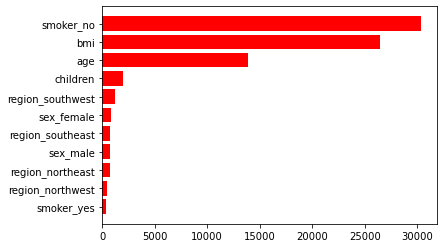

In [9]:
import numpy as np
# 変数重要度（入力変数ごとに決定木回帰の変数重要度の平均を取ったもの）
importances = nbr.booster_.feature_importance(importance_type = "gain")
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

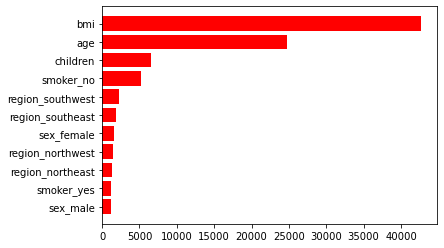

In [10]:
# 変数重要度（決定木のノードにその変数が現れた数の変数重要度として出す。）
importances = nbr.booster_.feature_importance(importance_type = "split")
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

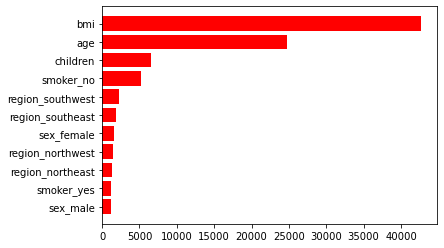

In [11]:
# 変数重要度（feature_importances_は`gain="split"`の結果を返している。）
importances = nbr.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

## 提出

In [12]:
test = test_df.drop(columns=['id'])

test_X = pd.get_dummies(test)
test_X.shape

(400, 11)

In [13]:
sample_submit[1] = nbr.predict(test_X)
sample_submit.to_csv('submit_lgbm.csv', header=None)
sample_submit.head()

,1
0,
13,0
23,2
27,0
28,0
29,0


### 特徴量エンジニアリング

**前提** 不健康・病気がちのほうが保険料は高い

仮説<br>
- 年齢が高いほど保険費は高い
- 男性のほうが保険費は高い
- 喫煙者のほうが保険費は高い
- BIMが高いほうが保険費は高い
- 南東に住む人のほうが保険費は高い
- 子供の有無も関係ある？

In [14]:
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,26,32.665465,3,0,1,1,0,0,0,1,0
1,41,29.798725,1,0,1,1,0,0,0,0,1
2,28,32.722029,0,0,1,0,1,0,1,0,0
3,20,38.429831,2,1,0,1,0,0,0,1,0
4,45,29.641854,1,1,0,1,0,0,1,0,0


In [15]:
X = X.drop(columns=['sex_female','smoker_no','region_southwest'])

カテゴリー変数の追加

In [16]:
def age_transform(x):
    if x <= 19:
        y = 0
    elif x <= 34:
        y = 1
    elif x <= 49:
        y = 2
    else:
        y = 3
    
    return y


X['generation'] = X.age.apply(lambda x: age_transform(x))

In [17]:
def children_transform(x):
    if x == 0:
        y = 0
    else:
        y = 1
    return y


X['have_children'] = X.children.apply(lambda x: children_transform(x))

In [18]:
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,generation,have_children
0,26,32.665465,3,1,0,0,0,1,1,1
1,41,29.798725,1,1,0,0,0,0,2,1
2,28,32.722029,0,1,1,0,1,0,1,0
3,20,38.429831,2,0,0,0,0,1,1,1
4,45,29.641854,1,0,0,0,1,0,2,1


lightGBM試す

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [20]:
feature_name = X.columns

In [21]:
# 勾配ブースティング決定木回帰モデルの学習
from lightgbm import LGBMClassifier
nbr = LGBMClassifier(learning_rate = 0.01,
                    n_estimators = 10000,
                    num_leaves = 4,
                    min_child_samples = 10)
nbr.fit(X_train, y_train,
        eval_set = (X_train, y_train), 
        early_stopping_rounds = 5, 
        verbose = 500)     # verboseは学習の様子をprintするiterationの間隔

Training until validation scores don't improve for 5 rounds
[500]	training's multi_logloss: 0.295754
[1000]	training's multi_logloss: 0.256363
[1500]	training's multi_logloss: 0.22755
[2000]	training's multi_logloss: 0.203706
[2500]	training's multi_logloss: 0.185338
[3000]	training's multi_logloss: 0.170104
[3500]	training's multi_logloss: 0.156072
[4000]	training's multi_logloss: 0.14341
[4500]	training's multi_logloss: 0.132394
[5000]	training's multi_logloss: 0.123151
[5500]	training's multi_logloss: 0.114462
[6000]	training's multi_logloss: 0.106557
[6500]	training's multi_logloss: 0.0987171
[7000]	training's multi_logloss: 0.0920729
[7500]	training's multi_logloss: 0.0862443
[8000]	training's multi_logloss: 0.0811019
[8500]	training's multi_logloss: 0.0767332
[9000]	training's multi_logloss: 0.0724312
[9500]	training's multi_logloss: 0.0688511
[10000]	training's multi_logloss: 0.0645831
Did not meet early stopping. Best iteration is:
[10000]	training's multi_logloss: 0.0645831


LGBMClassifier(learning_rate=0.01, min_child_samples=10, n_estimators=10000,
               num_leaves=4)

In [22]:
from sklearn.metrics import f1_score

f1_train = f1_score(y_train, nbr.predict(X_train), average='macro')
f1_test = f1_score(y_test, nbr.predict(X_test), average='macro')

# 評価結果の表示
print("f1_train:", f1_train, "f1_test", f1_test)

f1_train: 0.9822417960195099 f1_test 0.66476583941889


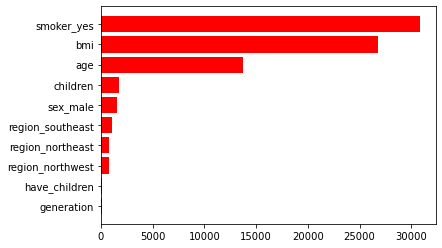

In [23]:
# 変数重要度（入力変数ごとに決定木回帰の変数重要度の平均を取ったもの）
importances = nbr.booster_.feature_importance(importance_type = "gain")
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

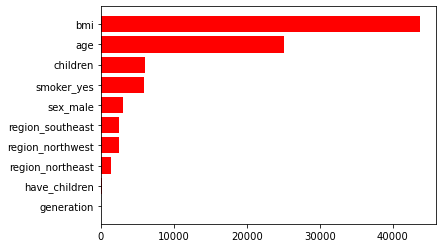

In [24]:
# 変数重要度（決定木のノードにその変数が現れた数の変数重要度として出す。）
importances = nbr.booster_.feature_importance(importance_type = "split")
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

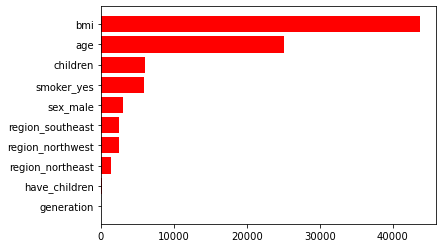

In [25]:
# 変数重要度（feature_importances_は`gain="split"`の結果を返している。）
importances = nbr.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

追加した変数は全く効いていない<br>
変数のカテゴライズは決定木においては同じこと？<br>
変数同士の掛け算を行うような変数を追加すべき

集約（aggregation）

In [26]:
X.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northeast',
       'region_northwest', 'region_southeast', 'generation', 'have_children'],
      dtype='object')

In [27]:
X_children =  X.groupby(['children']).agg(children_bmi_mean=('bmi','mean'),
                                                                        children_bmi_std=('bmi', 'std'),
                                                                        children_bmi_med=('bmi', 'median'),
                                                                        children_age_mean=('age','mean'),
                                                                        children_age_std=('age', 'std'),
                                                                        children_age_med=('age','median')
                                         ).reset_index()
X = pd.merge(X, X_children, on='children', how='left')

In [49]:
X_children

,children,children_bmi_mean,children_bmi_std,children_bmi_med,children_age_mean,children_age_std,children_age_med
0,0,32.026722,5.810841,32.044233,38.818646,15.695400,36.0
1,1,32.306045,5.650006,32.089585,38.882857,11.029291,40.0
2,2,33.501921,5.546305,33.163355,39.426087,10.794678,40.0
3,3,32.564906,5.870240,32.498988,40.395210,10.751833,43.0
4,4,31.386470,4.924951,29.186278,31.210526,12.185853,27.5
5,5,36.203007,5.884682,36.860882,42.875000,11.569565,42.0


In [28]:
X_smoker =  X.groupby(['smoker_yes']).agg(
    smoker_bmi_mean=('bmi','mean'),
    smoker_bmi_std=('bmi', 'std'),
    smoker_bmi_med=('bmi', 'median'),
    smoker_age_mean=('age','mean'),
    smoker_age_std=('age', 'std'),
    smoker_age_med=('age','median')
).reset_index()

X = pd.merge(X, X_smoker, on='smoker_yes', how='left')

In [29]:
X_northeast =  X.groupby(['region_northeast']).agg(
    northeast_bmi_mean=('bmi','mean'),
    northeast_bmi_std=('bmi', 'std'),
    northeast_bmi_med=('bmi', 'median'),
    northeast_age_mean=('age','mean'),
    northeast_age_std=('age', 'std'),
    northeast_age_med=('age','median')
).reset_index()

X = pd.merge(X, X_northeast, on='region_northeast', how='left')

In [30]:
X_northwest =  X.groupby(['region_northwest']).agg(
    northwest_bmi_mean=('bmi','mean'),
    northwest_bmi_std=('bmi', 'std'),
    northwest_bmi_med=('bmi', 'median'),
    northwest_age_mean=('age','mean'),
    northwest_age_std=('age', 'std'),
    northwest_age_med=('age','median')
).reset_index()

X = pd.merge(X, X_northwest, on='region_northwest', how='left')

In [31]:
X_southeast =  X.groupby(['region_southeast']).agg(
    southeast_bmi_mean=('bmi','mean'),
    southeast_bmi_std=('bmi', 'std'),
    southeast_bmi_med=('bmi', 'median'),
    southeast_age_mean=('age','mean'),
    southeast_age_std=('age', 'std'),
    southeast_age_med=('age','median')
).reset_index()

X = pd.merge(X, X_southeast, on='region_southeast', how='left')

In [32]:
X_gen_sex =  X.groupby(['generation','sex_male']).agg(
    gen_sex_bmi_mean=('bmi','mean'),
    gen_sex_bmi_std=('bmi', 'std'),
    gen_sex_bmi_med=('bmi', 'median')
).reset_index()

X = pd.merge(X, X_gen_sex, on=['generation','sex_male'], how='left')

In [33]:
X_have =  X.groupby(['have_children']).agg(
    have_bmi_mean=('bmi','mean'),
    have_bmi_std=('bmi', 'std'),
    have_bmi_med=('bmi', 'median'),
    have_age_mean=('age','mean'),
    have_age_std=('age', 'std'),
    have_age_med=('age','median')
).reset_index()

X = pd.merge(X, X_have, on='have_children', how='left')

In [34]:
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,generation,have_children,...,southeast_age_med,gen_sex_bmi_mean,gen_sex_bmi_std,gen_sex_bmi_med,have_bmi_mean,have_bmi_std,have_bmi_med,have_age_mean,have_age_std,have_age_med
0,26,32.665465,3,1,0,0,0,1,1,1,...,38,31.587860,5.562149,31.891343,32.805482,5.702064,32.418405,39.144431,11.131619,41
1,41,29.798725,1,1,0,0,0,0,2,1,...,40,32.509165,6.180497,31.969787,32.805482,5.702064,32.418405,39.144431,11.131619,41
2,28,32.722029,0,1,1,0,1,0,1,0,...,40,31.587860,5.562149,31.891343,32.026722,5.810841,32.044233,38.818646,15.695400,36
3,20,38.429831,2,0,0,0,0,1,1,1,...,38,32.419087,5.063690,32.498988,32.805482,5.702064,32.418405,39.144431,11.131619,41
4,45,29.641854,1,0,0,0,1,0,2,1,...,40,32.295473,5.521102,32.048875,32.805482,5.702064,32.418405,39.144431,11.131619,41


試す

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [36]:
feature_name = X.columns

In [37]:
# 勾配ブースティング決定木回帰モデルの学習
from lightgbm import LGBMClassifier
nbr = LGBMClassifier(learning_rate = 0.01,
                    n_estimators = 10000,
                    num_leaves = 4,
                    min_child_samples = 10)
nbr.fit(X_train, y_train,
        eval_set = (X_train, y_train), 
        early_stopping_rounds = 5, 
        verbose = 500)     # verboseは学習の様子をprintするiterationの間隔

Training until validation scores don't improve for 5 rounds
[500]	training's multi_logloss: 0.292777
[1000]	training's multi_logloss: 0.254003
[1500]	training's multi_logloss: 0.224274
[2000]	training's multi_logloss: 0.201158
[2500]	training's multi_logloss: 0.183828
[3000]	training's multi_logloss: 0.168877
[3500]	training's multi_logloss: 0.155861
[4000]	training's multi_logloss: 0.143211
[4500]	training's multi_logloss: 0.132185
[5000]	training's multi_logloss: 0.122644
[5500]	training's multi_logloss: 0.112654
[6000]	training's multi_logloss: 0.102791
[6500]	training's multi_logloss: 0.0945211
[7000]	training's multi_logloss: 0.0875473
[7500]	training's multi_logloss: 0.0809918
[8000]	training's multi_logloss: 0.0753209
[8500]	training's multi_logloss: 0.0702146
[9000]	training's multi_logloss: 0.0660524
[9500]	training's multi_logloss: 0.0621446
[10000]	training's multi_logloss: 0.0582619
Did not meet early stopping. Best iteration is:
[10000]	training's multi_logloss: 0.0582619


LGBMClassifier(learning_rate=0.01, min_child_samples=10, n_estimators=10000,
               num_leaves=4)

In [38]:
from sklearn.metrics import f1_score

f1_train = f1_score(y_train, nbr.predict(X_train), average='macro')
f1_test = f1_score(y_test, nbr.predict(X_test), average='macro')

# 評価結果の表示
print("f1_train:", f1_train, "f1_test", f1_test)

f1_train: 0.9861638587184292 f1_test 0.6705994686935725


In [47]:
X.shape

(1600, 49)

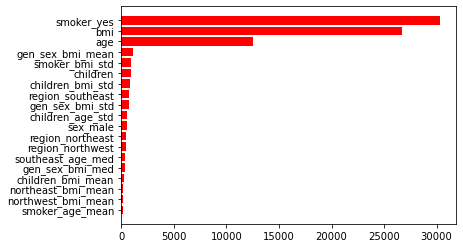

In [46]:
# 変数重要度（入力変数ごとに決定木回帰の変数重要度の平均を取ったもの）
importances = nbr.booster_.feature_importance(importance_type = "gain")
indices = np.argsort(importances)[30:]
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, nbr.predict(X_train))
cm_test = confusion_matrix(y_test, nbr.predict(X_test))

# 混同行列の表示
print(cm_train)
print(cm_test)

[[1005    0    0]
 [  11  147    0]
 [   0    0  117]]
[[240   7   4]
 [ 19  14   7]
 [  1   8  20]]


## 提出

In [55]:
test = test_df.drop(columns=['id'])

test_X = pd.get_dummies(test)

test_X = test_X.drop(columns=['sex_female','smoker_no','region_southwest'])

test_X['generation'] = test_X.age.apply(lambda x: age_transform(x))
test_X['have_children'] = test_X.children.apply(lambda x: children_transform(x))

test_X_children =  test_X.groupby(['children']).agg(children_bmi_mean=('bmi','mean'),
                                                                        children_bmi_std=('bmi', 'std'),
                                                                        children_bmi_med=('bmi', 'median'),
                                                                        children_age_mean=('age','mean'),
                                                                        children_age_std=('age', 'std'),
                                                                        children_age_med=('age','median')
                                         ).reset_index()
test_X = pd.merge(test_X, test_X_children, on='children', how='left')

test_X_smoker =  test_X.groupby(['smoker_yes']).agg(
    smoker_bmi_mean=('bmi','mean'),
    smoker_bmi_std=('bmi', 'std'),
    smoker_bmi_med=('bmi', 'median'),
    smoker_age_mean=('age','mean'),
    smoker_age_std=('age', 'std'),
    smoker_age_med=('age','median')
).reset_index()

test_X = pd.merge(test_X, test_X_smoker, on='smoker_yes', how='left')

test_X_northeast =  test_X.groupby(['region_northeast']).agg(
    northeast_bmi_mean=('bmi','mean'),
    northeast_bmi_std=('bmi', 'std'),
    northeast_bmi_med=('bmi', 'median'),
    northeast_age_mean=('age','mean'),
    northeast_age_std=('age', 'std'),
    northeast_age_med=('age','median')
).reset_index()

test_X = pd.merge(test_X, test_X_northeast, on='region_northeast', how='left')

test_X_northwest =  test_X.groupby(['region_northwest']).agg(
    northwest_bmi_mean=('bmi','mean'),
    northwest_bmi_std=('bmi', 'std'),
    northwest_bmi_med=('bmi', 'median'),
    northwest_age_mean=('age','mean'),
    northwest_age_std=('age', 'std'),
    northwest_age_med=('age','median')
).reset_index()

test_X = pd.merge(test_X, test_X_northwest, on='region_northwest', how='left')

test_X_southeast =  test_X.groupby(['region_southeast']).agg(
    southeast_bmi_mean=('bmi','mean'),
    southeast_bmi_std=('bmi', 'std'),
    southeast_bmi_med=('bmi', 'median'),
    southeast_age_mean=('age','mean'),
    southeast_age_std=('age', 'std'),
    southeast_age_med=('age','median')
).reset_index()

test_X = pd.merge(test_X, test_X_southeast, on='region_southeast', how='left')

test_X_gen_sex =  test_X.groupby(['generation','sex_male']).agg(
    gen_sex_bmi_mean=('bmi','mean'),
    gen_sex_bmi_std=('bmi', 'std'),
    gen_sex_bmi_med=('bmi', 'median')
).reset_index()

test_X = pd.merge(test_X, test_X_gen_sex, on=['generation','sex_male'], how='left')

test_X_have =  test_X.groupby(['have_children']).agg(
    have_bmi_mean=('bmi','mean'),
    have_bmi_std=('bmi', 'std'),
    have_bmi_med=('bmi', 'median'),
    have_age_mean=('age','mean'),
    have_age_std=('age', 'std'),
    have_age_med=('age','median')
).reset_index()

test_X = pd.merge(test_X, test_X_have, on='have_children', how='left')


test_X.shape

(400, 49)

In [56]:
sample_submit[1] = nbr.predict(test_X)
sample_submit.to_csv('submit_lgbm_overfitting.csv', header=None)
sample_submit.head()

,1
0,
13,0
23,2
27,0
28,0
29,0
